# Repeat the raw image plot from satellite_III

In [1]:
from e582utils.data_read import download
import numpy as np
import h5py
import sys
from e582lib.geolocate import fast_hist, slow_hist, fast_avg, slow_avg,make_plot 

filename = 'MYD021KM.A2016136.2015.006.2016138123353.h5'
download(filename)


MYD021KM.A2016136.2015.006.2016138123353.h5 already exists
and is 155338872 bytes
will not overwrite



Here is the corresponding red,green,blue color composite for the granule.

In [2]:
from IPython.display import Image
Image(url='http://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/aqua_136_2015.jpg',width=600)

In [3]:
h5_file=h5py.File(filename)

### **Read the radiance data from MODIS_SWATH_Type_L1B/Data Fields/EV_1KM_Emissive**

According to the [Modis channel listing](https://modis.gsfc.nasa.gov/about/specifications.php)
channel 31 is centered at 11 microns.  The Band_1KM_Emissive band listing says that this is index 10 of the the Emissive data array.  Note that Channel 26 is missing:

In [4]:
index31=10

my_name = 'EV_1KM_Emissive'
chan31=h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][my_name][index31,:,:]
scale=h5_file['MODIS_SWATH_Type_L1B']['Data Fields']['EV_1KM_Emissive'].attrs['radiance_scales'][...]
offset=h5_file['MODIS_SWATH_Type_L1B']['Data Fields']['EV_1KM_Emissive'].attrs['radiance_offsets'][...]
chan31_calibrated =(chan31 - offset[index31])*scale[index31]

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

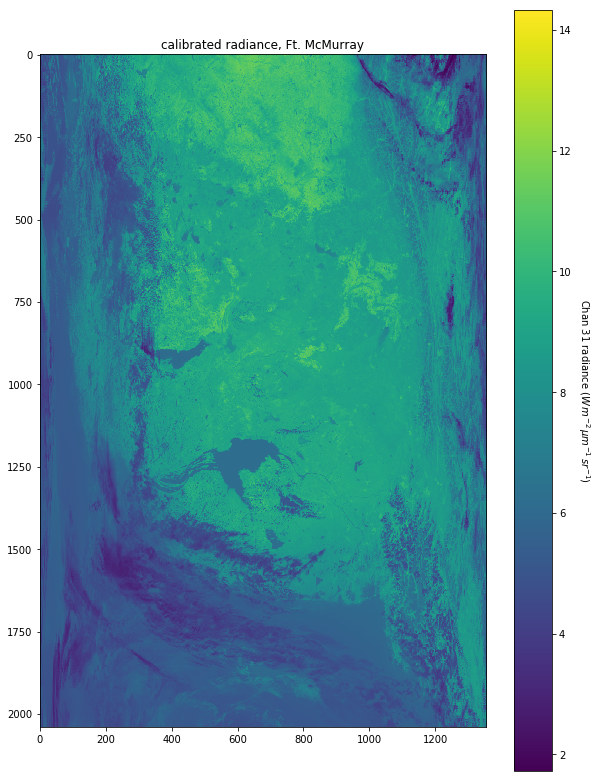

In [6]:
fig,ax = plt.subplots(1,1,figsize = (10,14))
CS=ax.imshow(chan31_calibrated)
cax=fig.colorbar(CS)
ax.set_title('calibrated radiance, Ft. McMurray')
out=cax.ax.set_ylabel('Chan 31 radiance $(W\,m^{-2}\,\mu m^{-1}\,sr^{-1}$)')
out.set_rotation(270)
out.set_verticalalignment('bottom')


In [7]:
filename='MYD03.A2016136.2015.006.2016138121537.h5'
download(filename)
geo_file = h5py.File(filename)
lon_data=geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields']['Longitude'][...]
lat_data=geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields']['Latitude'][...]


MYD03.A2016136.2015.006.2016138121537.h5 already exists
and is 41848985 bytes
will not overwrite



# Now time the slow and fast code to see how much of a speedup we can get on a small problem (gridding a corner of the scene)

In [8]:
slow_calc=False
test_rows=100
test_cols=200
row_slice = slice(0,test_rows)  # 0:test_rows
col_slice = slice(0,test_cols)  # 0:test_cols
lon_flat = lon_data[row_slice,col_slice].ravel()[:]
lat_flat = lat_data[row_slice,col_slice].ravel()[:]

lon_min= -115
lon_max = -93
num_lon_bins=10

lat_min = 50
lat_max = 65
num_lat_bins=20
#
# now run the function
#
if slow_calc:
    lon_hist=slow_hist(lon_flat,lon_min,lon_max,numbins=num_lon_bins)
    lat_hist=slow_hist(lat_flat,lat_min,lat_max,numbins=num_lon_bins)
else:
    lon_hist = fast_hist(lon_flat,lon_min,lon_max,numbins=num_lon_bins)
    lat_hist =  fast_hist(lat_flat,lat_min,lat_max,numbins=num_lat_bins)
chan31_slice=chan31_calibrated[row_slice,col_slice].ravel()
out1 = %timeit -o slow_hist(lon_flat,lon_min,lon_max,numbins=num_lon_bins)
out2 = %timeit -o fast_hist(lon_flat,lon_min,lon_max,numbins=num_lon_bins)
print('faster by a factor of: ',(out1.best/out2.best))

10 loops, best of 3: 52.9 ms per loop
1000 loops, best of 3: 535 µs per loop
faster by a factor of:  98.95628156203341


In [9]:
slow_calc=False
if slow_calc:
    gridded_image = slow_avg(lat_hist,lon_hist,chan31_slice)
else:
    gridded_image = fast_avg(lat_hist,lon_hist,chan31_slice)
out1 = %timeit -o  slow_avg(lat_hist,lon_hist,chan31_slice)
out2 = %timeit -o  fast_avg(lat_hist,lon_hist,chan31_slice)
print('faster by a factor of: ',(out1.best/out2.best))

1 loop, best of 3: 1.55 s per loop
10000 loops, best of 3: 149 µs per loop
faster by a factor of:  10448.39913586191


### So numba loops are giving us a speedup of almost 20,000 x straight python

Now we can geolocate the whole scene.  First find the scene corners using [find_corners](http://clouds.eos.ubc.ca/~phil/courses/atsc301/_modules/a301lib/geolocate.html#find_corners).  This also uses np.diff with the axis argument to try and determine how far apart the pixels are, so we can set the size of our histogram bins approporiately.

In [10]:
from importlib import reload
import e582lib.geolocate
from e582lib.geolocate import find_corners
corners=find_corners(lat_data,lon_data)
corners


space between pixels
--------------------

largest latitude spacing between rows:   0.0813 deg
largest longitude spacing between cols:   0.1310 deg



{'lat_0': 58.598548889160156,
 'lat_1': 47.283577,
 'lat_2': 69.913521,
 'llcrnrlat': 47.283577,
 'llcrnrlon': -143.51775,
 'lon_0': -118.03559875488281,
 'urcrnrlat': 69.913521,
 'urcrnrlon': -92.553444}

### The corners dictionary will be used by basemap below.  For now we can use the corner positions and the pixel spacing to get histogram limits:

Note that [fast_hist](http://clouds.eos.ubc.ca/~phil/courses/atsc301/_modules/a301lib/geolocate.html#fast_hist) not takes either a numbins or a binsize keyword argument to make the histogram bins.

In [11]:
lon_min= -144
lon_max = -92

lat_min = 47
lat_max = 70
binsize = 0.1

lon_hist = fast_hist(lon_data.ravel(),lon_min,lon_max,binsize=binsize)
lat_hist =  fast_hist(lat_data.ravel(),lat_min,lat_max,binsize=binsize)
gridded_image = fast_avg(lat_hist,lon_hist,chan31_calibrated.ravel())

In [12]:
lat_centers=(lat_hist['edges_vec'][1:] + lat_hist['edges_vec'][:-1])/2.
lon_centers=(lon_hist['edges_vec'][1:] + lon_hist['edges_vec'][:-1])/2.
lon_array,lat_array=np.meshgrid(lon_centers,lat_centers)

In [13]:
import numpy as np
lon,lat=np.meshgrid([1,2,3,4,5],[100,101,102,104])
lon
lat

array([[100, 100, 100, 100, 100],
       [101, 101, 101, 101, 101],
       [102, 102, 102, 102, 102],
       [104, 104, 104, 104, 104]])

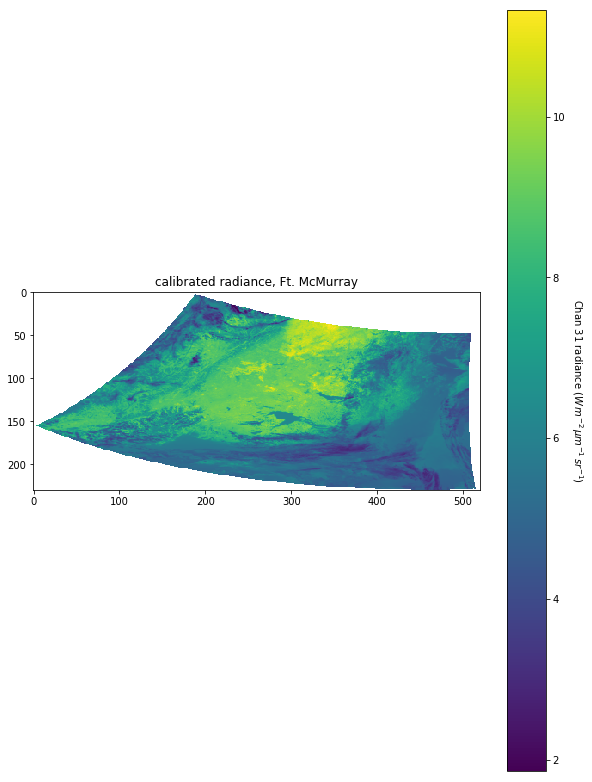

In [14]:
fig,ax = plt.subplots(1,1,figsize = (10,14))
CS=ax.imshow(gridded_image)
cax=fig.colorbar(CS)
ax.set_title('calibrated radiance, Ft. McMurray')
out=cax.ax.set_ylabel('Chan 31 radiance $(W\,m^{-2}\,\mu m^{-1}\,sr^{-1}$)')
out.set_rotation(270)
out.set_verticalalignment('bottom')

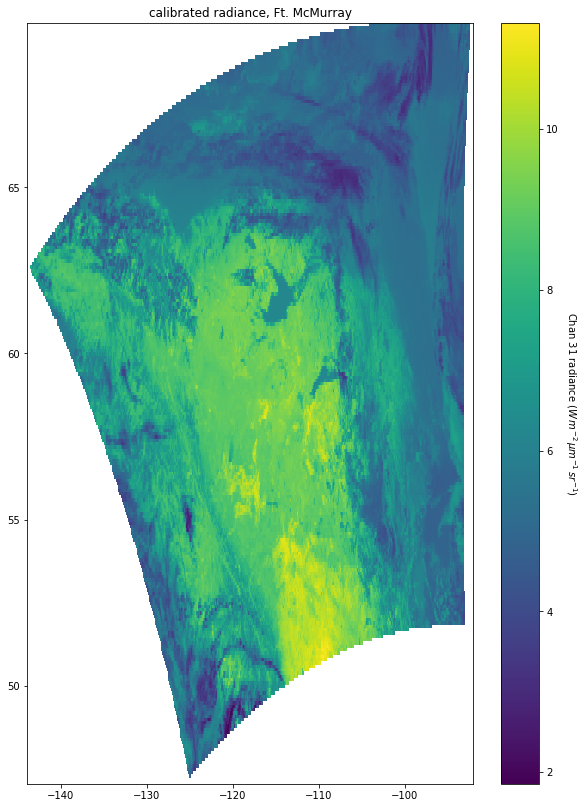

In [15]:
fig,ax = plt.subplots(1,1,figsize = (10,14))
masked_31 = np.ma.masked_invalid(gridded_image)
masked_31
lon_centers
lat_centers
CS=ax.pcolormesh(lon_centers,lat_centers,masked_31)
cax=fig.colorbar(CS)
ax.set_title('calibrated radiance, Ft. McMurray')
out=cax.ax.set_ylabel('Chan 31 radiance $(W\,m^{-2}\,\mu m^{-1}\,sr^{-1}$)')
out.set_rotation(270)
out.set_verticalalignment('bottom')

### Mapping the image

The cell below does a couple of things:

1) uses the autumn colormap with over, under and bad colors set separately

2) Uses the Normalize object to compress the palette so that all of the color range
   is used for data between 7 and 10 $W\,m^{-2}\,\mu m^{-1}\,sr^{-1}$
   Data larger than that is colored white, smaller pale blue (low saturation $\alpha$).
   Histogram cells that had 0 pixels were set to np.nan -- color those grey with set_bad
   
3) adds three new items to the corners dictionary -- the axis to plot into (ax), the resolution for basemap
   (choices are c (crude), l (low), i (intermediate), h (high), f (full)), and the map projection from
   [this list](http://matplotlib.org/basemap/users/mapsetup.html).  Note how I use [make_plot](http://clouds.eos.ubc.ca/~phil/courses/atsc301/codedoc.html#a301lib.geolocate.make_plot) to initialze the plot,
   and [meshgrid](http://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) to set up 2-dimensional latitude and longitude arrays from the histogram bins.  The basemap projection object proj maps lat,lon coords to
   x,y plotting coords.

/Users/phil/mini35/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/phil/mini35/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


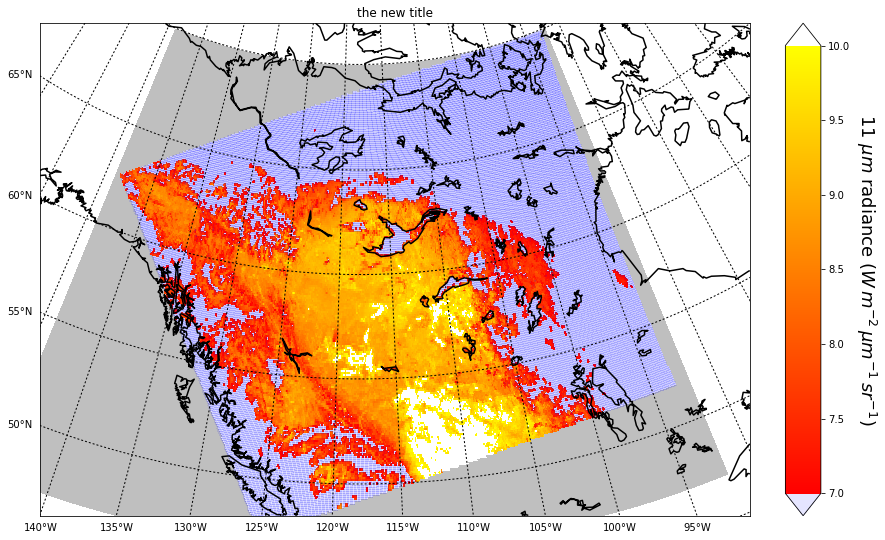

In [16]:
from matplotlib import cm
from matplotlib.colors import Normalize

cmap=cm.autumn  #see http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps
cmap.set_over('w')
cmap.set_under('b',alpha=0.1)
cmap.set_bad('0.75') #75% grey
#
# use all my colors on data between 7 and 10 
#
vmin= 7
vmax= 10
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
fig,ax = plt.subplots(1,1,figsize=(14,18))
corners['ax'] = ax
corners['resolution']='l'
corners['projection']='lcc'
corners['urcrnrlon'] = -70.
corners['urcrnrlat'] = 65.
corners['llcrnrlat'] = 46.
corners['llcrnrlon'] = -140.
proj = make_plot(corners)
lat_centers=(lat_hist['edges_vec'][1:] + lat_hist['edges_vec'][:-1])/2.
lon_centers=(lon_hist['edges_vec'][1:] + lon_hist['edges_vec'][:-1])/2.
lon_array,lat_array=np.meshgrid(lon_centers,lat_centers)
#
# translate every lat,lon pair in the scene to x,y plotting coordinates 
# for th Lambert projection
#
x,y=proj(lon_array,lat_array)
CS=proj.pcolormesh(x, y,masked_31, cmap=cmap, norm=the_norm)
CBar=proj.colorbar(CS, 'right', size='5%', pad='5%',extend='both')
CBar.set_label('11 $\mu m$ radiance ($W\,m^{-2}\,\mu m^{-1}\,sr^{-1}$)',
               rotation=270,verticalalignment='bottom',size=18)
_=ax.set_title('Modis Channel 11, May 15, 2016 -- Fort McMurray',size=22)
my_ax=proj.ax
ax.set(title='the new title')
ax.figure.canvas.draw()